Generate hourly prediction for future data by simply averaging historical data, and scale it according to the weekly prediction provided.

# Preparation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv, find_dotenv
import sys
sys.path.append('../')

In [2]:
# data directories
load_dotenv(find_dotenv(), verbose=True)
dir_project = os.getenv('PROJECT_ROOT')
dir_data_raw = os.path.join(dir_project, 'data/raw/')
dir_data_interim = os.path.join(dir_project, 'data/interim/')
dir_data_processed = os.path.join(dir_project, 'data/processed/')
dir_data_external = os.path.join(dir_project, 'data/external/')
dir_models = os.path.join(dir_project, 'models/')

Load data:  

In [3]:
path_data = os.path.join(dir_data_interim, 'Clean_Hourly_Data.csv')

In [4]:
df_origin = pd.read_csv(path_data)
df_origin.Date = pd.to_datetime(df_origin.Date + ' ' + df_origin.Hour)
df_origin.set_index('Date', inplace=True)

In [5]:
df_origin.head()

,Hour,HOEP,Ontario.Demand,NUCLEAR,GAS,HYDRO,WIND,SOLAR,BIOFUEL,Temp,Holidays,season_Fall,season_Spring,season_Summer,season_Winter,month,dayofweek,CDD,HDD
Date,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,00:00:00,3.28,14960,11564,957,3173,2504,0.0,20,-6.2,1,0,0,0,1,1,3,0.0,24.53
2015-01-01 01:00:00,01:00:00,0.00,14476,11560,946,3100,2262,0.0,20,-6.0,1,0,0,0,1,1,3,0.0,24.33
2015-01-01 02:00:00,02:00:00,0.00,13979,11560,947,3051,2025,0.0,20,-6.2,1,0,0,0,1,1,3,0.0,24.53
2015-01-01 03:00:00,03:00:00,0.00,13670,11444,949,3086,1950,0.0,22,-6.0,1,0,0,0,1,1,3,0.0,24.33
2015-01-01 04:00:00,04:00:00,0.00,13567,11174,946,3131,2015,0.0,21,-6.0,1,0,0,0,1,1,3,0.0,24.33


In [6]:
len(df_origin)

48360

In [7]:
independ_vars = ['HOEP', 'Ontario.Demand', 'Temp', 'NUCLEAR', 'GAS', 'HYDRO', 'WIND', 'SOLAR', 'BIOFUEL']
df = df_origin[independ_vars]

Leave `CDD`, `HDD` aside since it's calculated from `Temp`.

Missing `dew point` in the data.

# Split Data

In [104]:
df_train = df[df.index.year < 2018].copy()
df_test = df[df.index.year >= 2018].copy()

# Average hourly data

Since the largest seasonality is annual, we will split historical data into years and average the data of every hour in the year.  
So we will index by Month/Year/Hour:

In [9]:
df_train['Month'] = df_train.index.month
df_train['Day'] = df_train.index.day
df_train['Hour'] = df_train.index.hour

df_train.set_index(['Month', 'Day', 'Hour'], inplace=True)

In [10]:
df_train

HOEP  Ontario.Demand  Temp  NUCLEAR   GAS  HYDRO  WIND  \
Month Day Hour                                                            
1     1   0      3.28           14960  -6.2    11564   957   3173  2504   
          1      0.00           14476  -6.0    11560   946   3100  2262   
          2      0.00           13979  -6.2    11560   947   3051  2025   
          3      0.00           13670  -6.0    11444   949   3086  1950   
          4      0.00           13567  -6.0    11174   946   3131  2015   
...               ...             ...   ...      ...   ...    ...   ...   
12    31  19    40.04           18706 -13.7    11681  3032   5110  1201   
          20    39.71           18284 -14.5    11675  2853   4978  1180   
          21    39.37           17772 -15.0    11682  2721   4525  1214   
          22    39.79           17228 -15.5    11677  2715   3918  1164   
          23    42.56           16842 -15.8    11680  2526   3739  1049   

                SOLAR  BIOFUEL  
Month Day Hour                  
1     1   0       0.0       20  
          1       0.0       20  
          2       0.0       20  
          3       0.0       22  
          4       0.0       21  
...               ...      ...  
12    31  19      0.0        8  
          20      0.0        6  
          21      0.0        0  
          22      0.0        1  
          23      0.0        3  

[26304 rows x 9 columns]

In [11]:
df_average = df_train.mean(level=[0,1,2])
df_average

HOEP  Ontario.Demand      Temp       NUCLEAR          GAS  \
Month Day Hour                                                                  
1     1   0     0.730000    13966.333333 -1.200000  11448.000000   703.333333   
          1    -0.803333    13520.333333 -1.200000  11390.666667   699.666667   
          2    -1.410000    13063.333333 -1.466667  11353.333333   700.333333   
          3    -1.466667    12834.333333 -1.333333  11159.666667   702.333333   
          4    -1.480000    12748.666667 -1.333333  11065.333333   700.666667   
...                  ...             ...       ...           ...          ...   
2     29  19    0.000000    18853.000000 -1.800000  11357.000000  1181.000000   
          20    4.820000    18701.000000 -4.000000  11358.000000  1176.000000   
          21    1.790000    18022.000000 -4.800000  11357.000000  1169.000000   
          22    0.970000    17083.000000 -5.300000  11358.000000  1170.000000   
          23    6.030000    16224.000000 -5.600000  11358.000000   991.000000   

                      HYDRO         WIND  SOLAR    BIOFUEL  
Month Day Hour                                              
1     1   0     2874.000000  2064.000000    0.0   8.000000  
          1     2874.000000  1913.000000    0.0   8.000000  
          2     2842.333333  1601.666667    0.0   9.666667  
          3     2861.666667  1561.000000    0.0  10.000000  
          4     2879.000000  1507.000000    0.0   8.000000  
...                     ...          ...    ...        ...  
2     29  19    5409.000000  2683.000000    0.0   0.000000  
          20    5335.000000  2756.000000    0.0   0.000000  
          21    5179.000000  2273.000000    0.0   0.000000  
          22    5012.000000  1910.000000    0.0   0.000000  
          23    4825.000000  1533.000000    0.0   0.000000  

[8784 rows x 9 columns]

8784 = 366*24 since there are 366 days in year 2016 (leap year).

# Visualize

The historical (train) data is from 2015/01/01 to 2018/12/31.

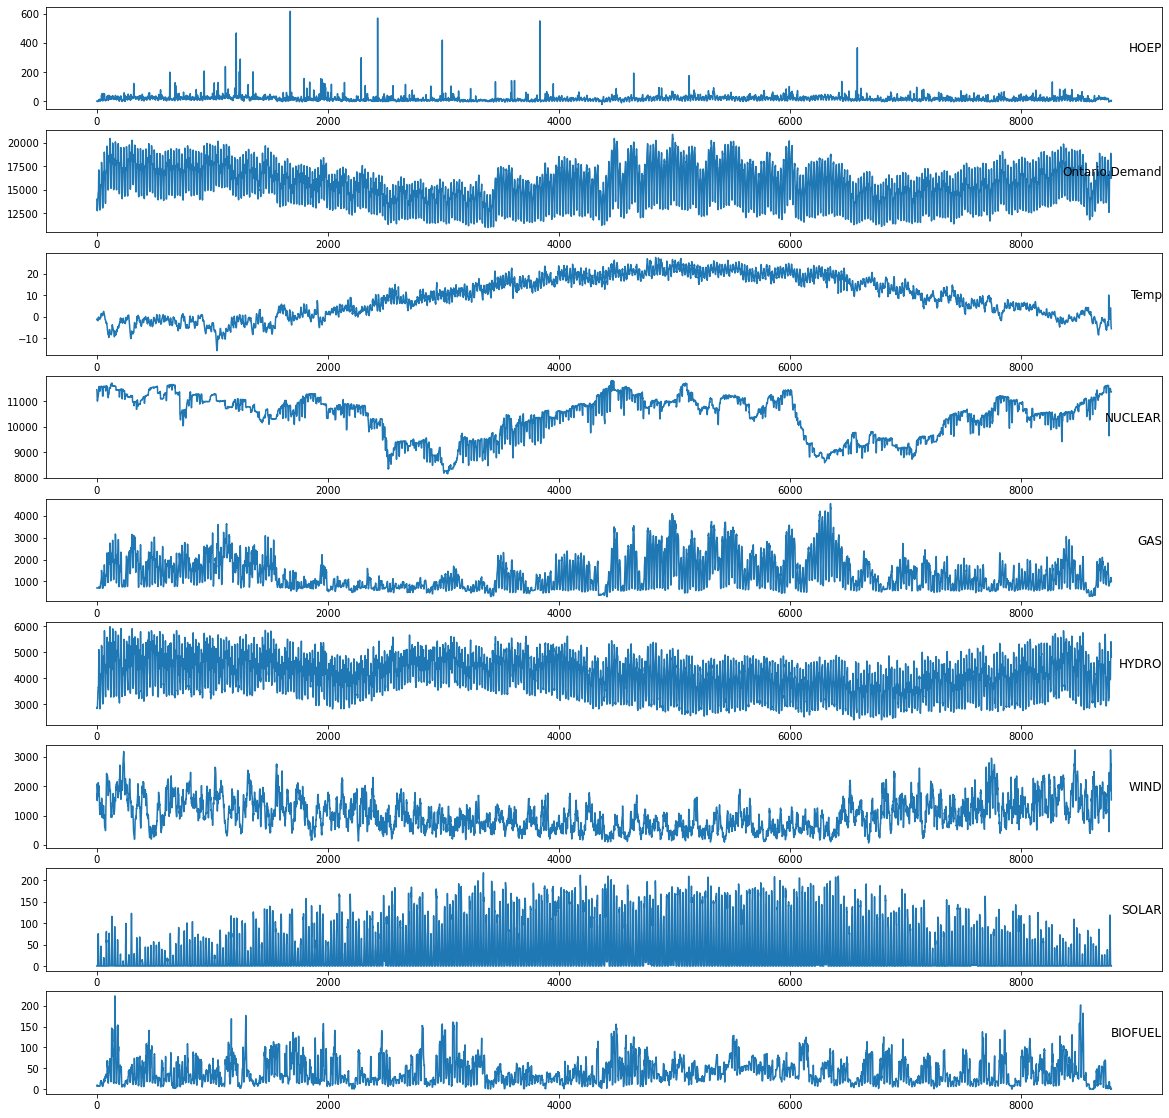

In [12]:
values = df_average.values
# specify columns to plot
cols = range(0, values.shape[1])
i = 1
# plot each column
plt.figure(figsize=(20, 20))
for col in cols:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[:, col])
	plt.title(df.columns[col], y=0.5, loc='right')
	i += 1
plt.show()

- One month sample data:

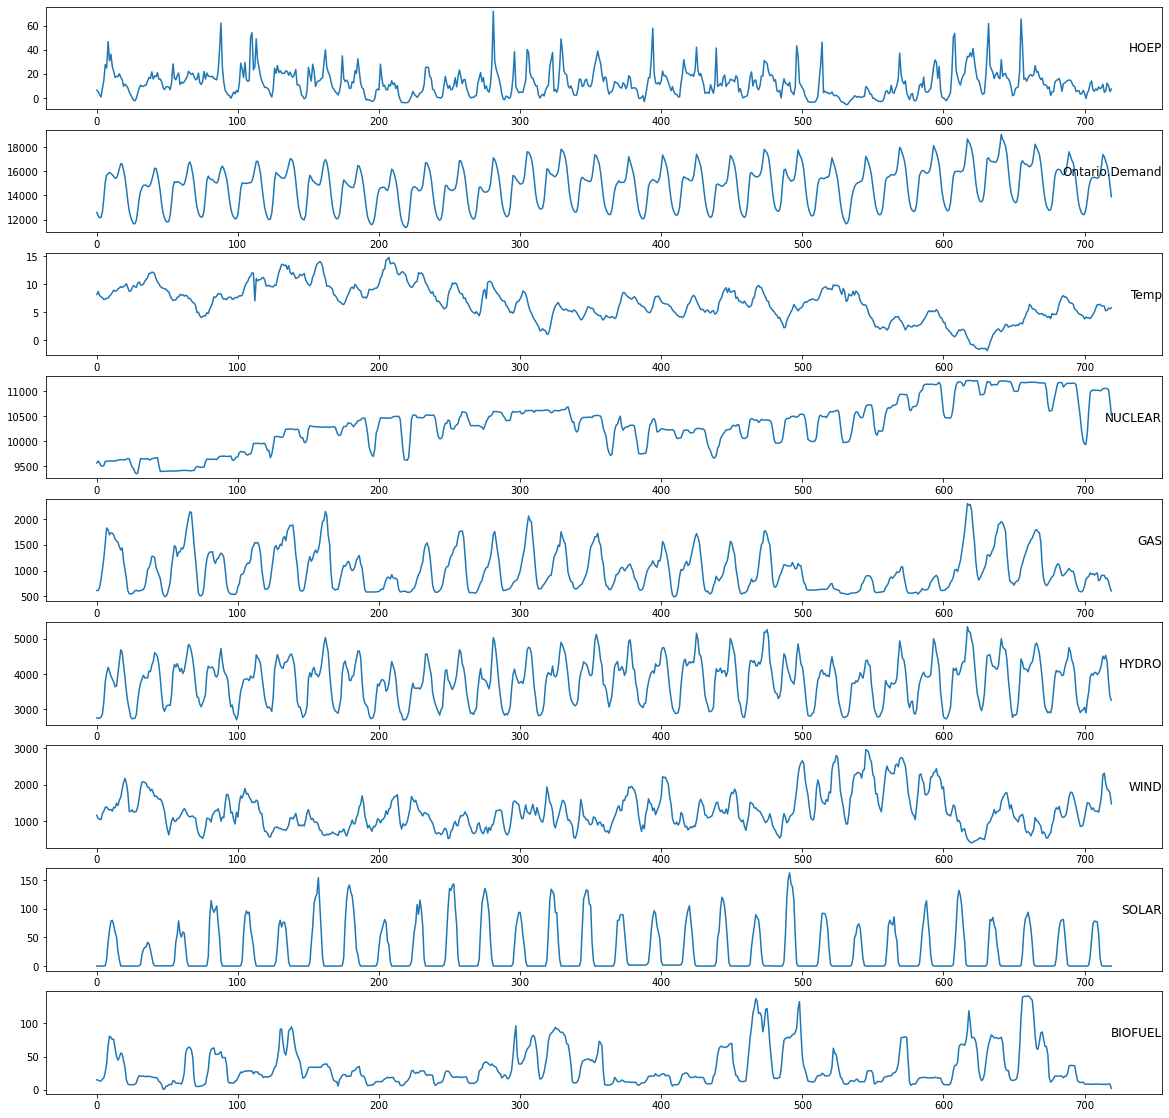

In [13]:
cols = range(0, values.shape[1])
i = 1
# plot each column
plt.figure(figsize=(20, 20))
for col in cols:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[720*10:720*11, col])
	plt.title(df.columns[col], y=0.5, loc='right')
	i += 1
plt.show()

- One day sample:

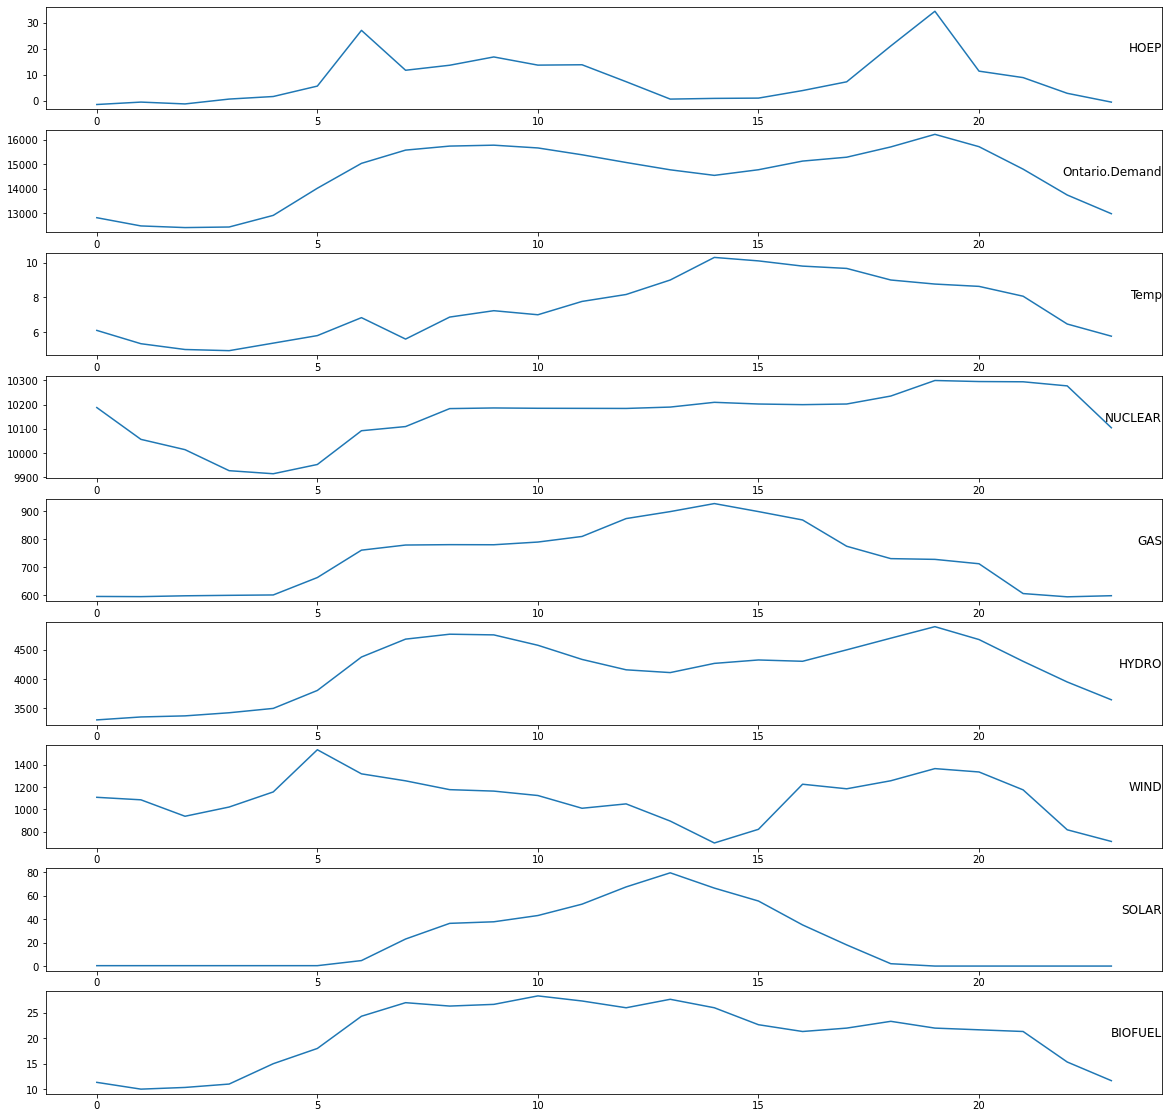

In [14]:
cols = range(0, values.shape[1])
i = 1
# plot each column
plt.figure(figsize=(20, 20))
for col in cols:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[24*100:24*101, col])
	plt.title(df.columns[col], y=0.5, loc='right')
	i += 1
plt.show()

We can find clear seasonnal and daily patterns on most of the variables.

One thing that misses is this average **doesn't count weekly pattern**, nor does it capture some holiday information.

# Scale by weekly outlook

## Load the weekly outlook:

In [15]:
df_outlook_origin = pd.read_excel(os.path.join(dir_data_raw, 'Data 18 months Outlook/03-01-2018/03012018.xlsx'), sheet_name='Feuil1')
independ_vars = ['Ontario ED', 'Normal Average Temperature (°C)', 'Expected Nuclear Output', 
                 'Expected Hydro Output', 'Expected Wind Output', 'Expected Self-Scheduling & Intermittent Output']
df_outlook = df_outlook_origin[['Date (week ending)', 'HOEP'] + independ_vars].copy()

In [16]:
df_outlook.head(2)

,Date (week ending),HOEP,Ontario ED,Normal Average Temperature (°C),Expected Nuclear Output,Expected Hydro Output,Expected Wind Output,Expected Self-Scheduling & Intermittent Output
0,2018-04-01 23:00:00,15.836429,2468.42979,4.619048,10302,2794,1492.0904,94.479151
1,2018-04-08 23:00:00,29.797440,2439.56878,6.466667,9425,2794,1492.0904,69.605019


In [17]:
df_outlook['Week'] = df_outlook['Date (week ending)'].apply(lambda x: x.isocalendar()[1])

Average Demand into hourly:

In [18]:
# GWh -> MWh, need *1000
df_outlook['Ontario ED'] = df_outlook['Ontario ED']*1000/168

Rename cols to match the other df:

In [19]:
df_outlook.rename(columns={"Ontario ED": "Ontario.Demand", "Normal Average Temperature (°C)": "Temp", 
                          'Expected Nuclear Output': 'NUCLEAR', 'Expected Hydro Output': 'HYDRO', 
                          'Expected Wind Output': 'WIND', 'Expected Self-Scheduling & Intermittent Output': 'Intermittent_Output'}, 
                  inplace = True)

In [26]:
independ_vars = df_outlook.drop(columns=['Date (week ending)', 'HOEP', 'Week']).columns.to_list()

In [27]:
independ_vars

['Ontario.Demand', 'Temp', 'NUCLEAR', 'HYDRO', 'WIND', 'Intermittent_Output']

In [23]:
df_outlook

,Date (week ending),HOEP,Ontario.Demand,Temp,NUCLEAR,HYDRO,WIND,Intermittent_Output,Week
0,2018-04-01 23:00:00,15.836429,14693.034464,4.619048,10302,2794,1492.0904,94.479151,13
1,2018-04-08 23:00:00,29.797440,14521.242738,6.466667,9425,2794,1492.0904,69.605019,14
2,2018-04-15 23:00:00,35.876845,14215.236607,8.085714,9425,2794,1308.3592,69.605019,15
3,2018-04-22 23:00:00,37.610476,13977.730893,9.409524,9425,2794,1308.3592,69.605019,16
4,2018-04-29 23:00:00,15.065714,13853.672559,10.752381,9425,2794,1308.3592,69.605019,17
...,...,...,...,...,...,...,...,...,...
75,2019-09-08 23:00:00,15.114405,14000.714030,16.757143,11005,2048,897.4800,78.367627,36
76,2019-09-15 23:00:00,12.700714,14404.269340,17.333333,10192,2048,897.4800,78.367627,37
77,2019-09-22 23:00:00,16.508750,14202.637969,15.376190,10192,2048,897.4800,78.367627,38
78,2019-09-29 23:00:00,10.606250,13906.617972,11.566667,10192,2048,897.4800,78.367627,39


## Compute historical weekly average:

There are 52 or 53 ISO weeks in a year, for simplification, we won't concern too much about the distinction between week 52, 53 and 1.

Take the mean of every 7 days in the df_average as the weekly average:

In [28]:
df_average['Week'] = np.arange(len(df_average))//(7*24) + 1

In [29]:
df_average_weekly = df_average.groupby('Week').mean()

Align the variables with the outlook:  
`GAS + SOLAR + BIOFUEL = Expected Self-Scheduling & Intermittent Output`

In [30]:
df_average_weekly['Intermittent_Output'] = df_average_weekly[['SOLAR', 'BIOFUEL']].sum(axis=1)

In [31]:
df_average_weekly.drop(columns = ['SOLAR', 'BIOFUEL', 'GAS'], inplace=True)

In [32]:
df_average_weekly.head()

,HOEP,Ontario.Demand,Temp,NUCLEAR,HYDRO,WIND,Intermittent_Output
Week,,,,,,,
1,16.855119,16449.585317,-3.520437,11485.662698,4312.841270,1491.494048,56.333333
2,20.944226,17286.192460,-3.796627,11242.079365,4516.591270,1711.783730,44.541667
3,23.290437,17056.867063,-2.059508,11195.894841,4558.428571,1122.202381,58.505952
4,20.157222,16643.732143,-1.447619,11411.740079,4485.926587,1264.430556,37.898810
5,20.918075,16887.718254,-2.704746,10944.220238,4460.285714,1554.204365,51.172619


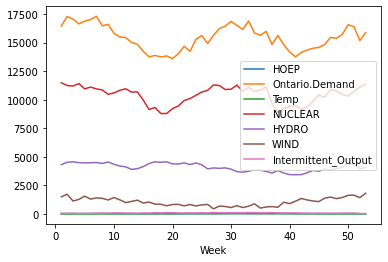

In [33]:
df_average_weekly.plot()

By comparison:

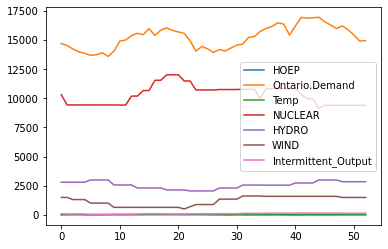

In [34]:
df_outlook[['HOEP'] + independ_vars][:53].plot()

Historical average price vs. realized price:

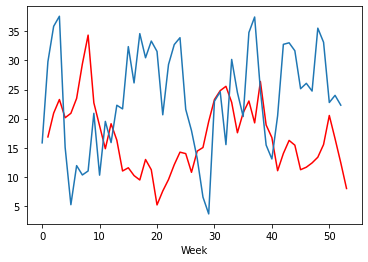

In [36]:
df_average_weekly['HOEP'].plot(color='r')
df_outlook['HOEP'][:53].plot()

The corresponding variables are in the same magnitude.

## Transform weekly outlook into hourly by scaling the hourly average

### Calculate the scale

In [37]:
print(df_outlook.shape)
print(df_average_weekly.shape)

(80, 9)
(53, 7)


In [38]:
df_average_weekly.head(1)

,HOEP,Ontario.Demand,Temp,NUCLEAR,HYDRO,WIND,Intermittent_Output
Week,,,,,,,
1,16.855119,16449.585317,-3.520437,11485.662698,4312.84127,1491.494048,56.333333


In [39]:
df_outlook.head(1)

,Date (week ending),HOEP,Ontario.Demand,Temp,NUCLEAR,HYDRO,WIND,Intermittent_Output,Week
0,2018-04-01 23:00:00,15.836429,14693.034464,4.619048,10302,2794,1492.0904,94.479151,13


In [40]:
df_outlook_scale = df_outlook.copy()

In [41]:
for i, row in df_outlook_scale.iterrows():
    week = row['Week']
    for var in df_average_weekly.columns:
        df_outlook_scale[var+'_scale'] = row[var] / df_average_weekly.loc[week, var]

In [42]:
df_outlook_scale

,Date (week ending),HOEP,Ontario.Demand,Temp,NUCLEAR,HYDRO,WIND,Intermittent_Output,Week,HOEP_scale,Ontario.Demand_scale,Temp_scale,NUCLEAR_scale,HYDRO_scale,WIND_scale,Intermittent_Output_scale
0,2018-04-01 23:00:00,15.836429,14693.034464,4.619048,10302,2794,1492.0904,94.479151,13,0.528435,0.997024,0.798249,1.089906,0.668693,1.504096,1.001364
1,2018-04-08 23:00:00,29.797440,14521.242738,6.466667,9425,2794,1492.0904,69.605019,14,0.528435,0.997024,0.798249,1.089906,0.668693,1.504096,1.001364
2,2018-04-15 23:00:00,35.876845,14215.236607,8.085714,9425,2794,1308.3592,69.605019,15,0.528435,0.997024,0.798249,1.089906,0.668693,1.504096,1.001364
3,2018-04-22 23:00:00,37.610476,13977.730893,9.409524,9425,2794,1308.3592,69.605019,16,0.528435,0.997024,0.798249,1.089906,0.668693,1.504096,1.001364
4,2018-04-29 23:00:00,15.065714,13853.672559,10.752381,9425,2794,1308.3592,69.605019,17,0.528435,0.997024,0.798249,1.089906,0.668693,1.504096,1.001364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2019-09-08 23:00:00,15.114405,14000.714030,16.757143,11005,2048,897.4800,78.367627,36,0.528435,0.997024,0.798249,1.089906,0.668693,1.504096,1.001364
76,2019-09-15 23:00:00,12.700714,14404.269340,17.333333,10192,2048,897.4800,78.367627,37,0.528435,0.997024,0.798249,1.089906,0.668693,1.504096,1.001364
77,2019-09-22 23:00:00,16.508750,14202.637969,15.376190,10192,2048,897.4800,78.367627,38,0.528435,0.997024,0.798249,1.089906,0.668693,1.504096,1.001364
78,2019-09-29 23:00:00,10.606250,13906.617972,11.566667,10192,2048,897.4800,78.367627,39,0.528435,0.997024,0.798249,1.089906,0.668693,1.504096,1.001364


### Expand to hourly  
Do it week by week:

In [43]:
list_dfs_outlook_hourly = [None]*len(df_outlook_scale)

In [44]:
df_average.head(2)

HOEP  Ontario.Demand  Temp       NUCLEAR         GAS  \
Month Day Hour                                                             
1     1   0     0.730000    13966.333333  -1.2  11448.000000  703.333333   
          1    -0.803333    13520.333333  -1.2  11390.666667  699.666667   

                 HYDRO    WIND  SOLAR  BIOFUEL  Week  
Month Day Hour                                        
1     1   0     2874.0  2064.0    0.0      8.0     1  
          1     2874.0  1913.0    0.0      8.0     1

In [45]:
df_average.columns

Index(['HOEP', 'Ontario.Demand', 'Temp', 'NUCLEAR', 'GAS', 'HYDRO', 'WIND',
       'SOLAR', 'BIOFUEL', 'Week'],
      dtype='object')

In [46]:
import copy
for i, row in df_outlook_scale.iterrows():
    week = row.Week
    df_outlook_hourly_ithWeek = df_average[df_average.Week==week].copy()
    for var in ['Ontario.Demand', 'Temp', 'NUCLEAR', 'HYDRO', 'WIND']:
        df_outlook_hourly_ithWeek[var + '_scaled'] = df_outlook_hourly_ithWeek[var]*row[var+'_scale']
    for var in ['SOLAR', 'BIOFUEL']:
        df_outlook_hourly_ithWeek[var + '_scaled'] = df_outlook_hourly_ithWeek[var]*row['Intermittent_Output_scale']
    
    list_dfs_outlook_hourly[i] = df_outlook_hourly_ithWeek.copy()

In [47]:
df_outlook_hourly_scaled = pd.concat(list_dfs_outlook_hourly)

In [48]:
cols = ['Week','HOEP',
        'Ontario.Demand_scaled',
        'Temp_scaled',
        'NUCLEAR_scaled',
        'HYDRO_scaled',
        'WIND_scaled',
        'SOLAR_scaled',
        'BIOFUEL_scaled',
        'Ontario.Demand',
        'Temp',
        'NUCLEAR',
        'GAS',
        'HYDRO',
        'WIND',
        'SOLAR',
        'BIOFUEL']  # rearrange order

In [49]:
df_outlook_hourly_scaled = df_outlook_hourly_scaled[cols]

In [50]:
df_outlook_hourly_scaled.rename(columns = {'Ontario.Demand': 'Ontario.Demand_history', 'Temp': 'Temp_history',
                                          'NUCLEAR': 'NUCLEAR_history', 'GAS': 'GAS_history', 'HYDRO': 'HYDRO_history',
                                          'WIND': 'WIND_history', 'SOLAR': 'SOLAR_history', 'BIOFUEL': 'BIOFUEL_history'},
                               inplace=True)

In [51]:
df_outlook_hourly_scaled

Week       HOEP  Ontario.Demand_scaled  Temp_scaled  \
Month Day Hour                                                        
3     26  0       13   2.263333           13163.038985     1.543282   
          1       13   4.623333           12939.040998     1.170765   
          2       13   4.933333           12850.638231     0.984507   
          3       13   5.213333           12897.830686     0.984507   
          4       13   8.233333           13201.258226     0.638599   
...              ...        ...                    ...          ...   
10    7   19      40  12.743333           16130.181461    14.528135   
          20      40  11.370000           15445.226192    13.809711   
          21      40  13.436667           14466.148937    13.676669   
          22      40  13.590000           13339.844518    13.676669   
          23      40   7.340000           12483.068834    13.304153   

                NUCLEAR_scaled  HYDRO_scaled  WIND_scaled  SOLAR_scaled  \
Month Day Hour                                                            
3     26  0       11502.863961   1987.355039  1867.085004           0.0   
          1       11504.680471   1948.793753  1888.643719           0.0   
          2       11502.863961   1986.240551  1820.959381           0.0   
          3       11508.313489   2019.675192  1803.912955           0.0   
          4       11549.366601   2234.994277  1518.134638           0.0   
...                        ...           ...          ...           ...   
10    7   19      10679.621913   2643.565586  2389.006456           0.0   
          20      10669.449460   2480.181642  2293.245652           0.0   
          21      10668.722857   2178.601183  2074.650308           0.0   
          22      10673.809083   2017.223318  1806.921148           0.0   
          23      10678.168705   1856.291248  1607.377691           0.0   

                BIOFUEL_scaled  Ontario.Demand_history  Temp_history  \
Month Day Hour                                                         
3     26  0           7.677126            13202.333333      1.933333   
          1           7.677126            12977.666667      1.466667   
          2           7.009549            12889.000000      1.233333   
          3           7.343337            12936.333333      1.233333   
          4           8.678490            13240.666667      0.800000   
...                        ...                     ...           ...   
10    7   19         85.449745            16178.333333     18.200000   
          20         81.444289            15491.333333     17.300000   
          21         69.094130            14509.333333     17.133333   
          22         26.369257            13379.666667     17.133333   
          23         17.356980            12520.333333     16.666667   

                NUCLEAR_history  GAS_history  HYDRO_history  WIND_history  \
Month Day Hour                                                              
3     26  0        10554.000000   597.333333    2972.000000   1241.333333   
          1        10555.666667   598.333333    2914.333333   1255.666667   
          2        10554.000000   599.333333    2970.333333   1210.666667   
          3        10559.000000   599.333333    3020.333333   1199.333333   
          4        10596.666667   600.333333    3342.333333   1009.333333   
...                         ...          ...            ...           ...   
10    7   19        9798.666667  1488.333333    3953.333333   1588.333333   
          20        9789.333333  1356.666667    3709.000000   1524.666667   
          21        9788.666667  1193.666667    3258.000000   1379.333333   
          22        9793.333333   989.000000    3016.666667   1201.333333   
          23        9797.333333   726.000000    2776.000000   1068.666667   

                SOLAR_history  BIOFUEL_history  
Month Day Hour                                  
3     26  0               0.0         7.666667  
          1               0.0 

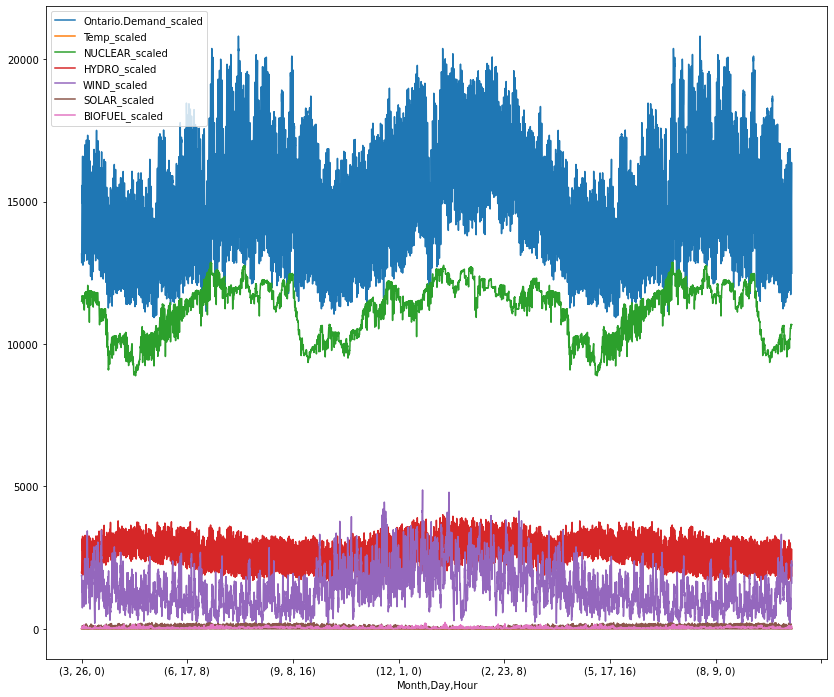

In [100]:
df_outlook_hourly_scaled.loc[:,'Ontario.Demand_scaled': 'BIOFUEL_scaled'].plot(figsize=(14,12))

Compare with simple average no scaling:

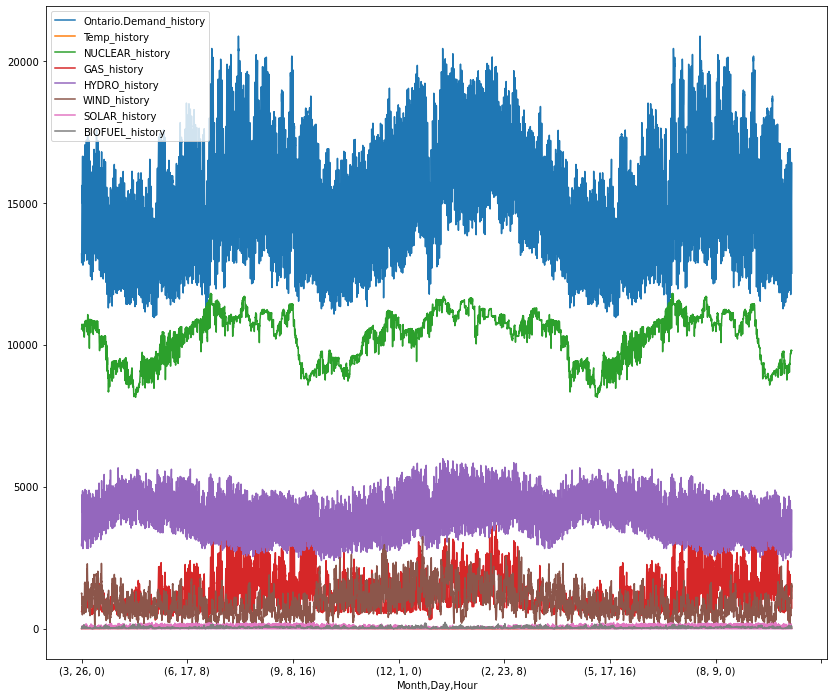

In [102]:
df_outlook_hourly_scaled.loc[:,'Ontario.Demand_history': 'BIOFUEL_history'].plot(figsize=(14,12))

Realized Data:

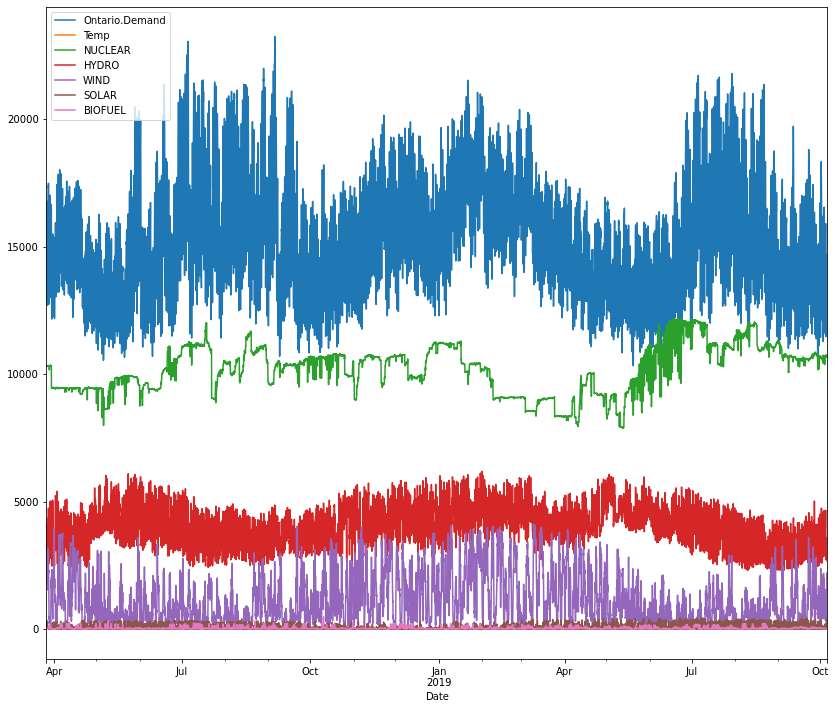

In [110]:
df_test.drop(columns=['HOEP', 'GAS'])[(df_test.index>'2018-03-26') & (df_test.index<'2019-10-06')].plot(figsize=(14,12))

## Format transform

In [91]:
target_cols = ['Date (week ending)', 'HOEP', 'Ontario ED', 'Normal Average Temperature (Â°C)', 'Expected Nuclear Output', 'Expected Hydro Output', 'Expected Wind Output', 'Expected Self-Scheduling & Intermittent Output']

In [55]:
df_outlook_hourly_scaled['Expected Self-Scheduling & Intermittent Output'] = \
df_outlook_hourly_scaled['SOLAR_scaled'] + df_outlook_hourly_scaled['BIOFUEL_scaled']

In [63]:
list_to_output = cols = ['HOEP',
        'Ontario.Demand_scaled',
        'Temp_scaled',
        'NUCLEAR_scaled',
        'HYDRO_scaled',
        'WIND_scaled',
        'Expected Self-Scheduling & Intermittent Output']

In [85]:
df_outlook_hourly_scaled_output = df_outlook_hourly_scaled[list_to_output].copy()

In [86]:
starting_time = df_outlook['Date (week ending)'][0] - pd.Timedelta('7 day')

In [87]:
df_outlook_hourly_scaled_output['Date (week ending)'] = \
pd.date_range(start=starting_time, periods=len(df_outlook_hourly_scaled_output)+1, closed='right', freq='H')

In [88]:
df_outlook_hourly_scaled_output.set_index('Date (week ending)', inplace=True)
df_outlook_hourly_scaled_output.reset_index(inplace=True)

In [92]:
df_outlook_hourly_scaled_output.columns = target_cols

In [93]:
df_outlook_hourly_scaled_output

,Date (week ending),HOEP,Ontario ED,Normal Average Temperature (Â°C),Expected Nuclear Output,Expected Hydro Output,Expected Wind Output,Expected Self-Scheduling & Intermittent Output
0,2018-03-26 00:00:00,2.263333,13163.038985,1.543282,11502.863961,1987.355039,1867.085004,7.677126
1,2018-03-26 01:00:00,4.623333,12939.040998,1.170765,11504.680471,1948.793753,1888.643719,7.677126
2,2018-03-26 02:00:00,4.933333,12850.638231,0.984507,11502.863961,1986.240551,1820.959381,7.009549
3,2018-03-26 03:00:00,5.213333,12897.830686,0.984507,11508.313489,2019.675192,1803.912955,7.343337
4,2018-03-26 04:00:00,8.233333,13201.258226,0.638599,11549.366601,2234.994277,1518.134638,8.678490
...,...,...,...,...,...,...,...,...
13435,2019-10-06 19:00:00,12.743333,16130.181461,14.528135,10679.621913,2643.565586,2389.006456,85.449745
13436,2019-10-06 20:00:00,11.370000,15445.226192,13.809711,10669.449460,2480.181642,2293.245652,81.444289
13437,2019-10-06 21:00:00,13.436667,14466.148937,13.676669,10668.722857,2178.601183,2074.650308,69.094130
13438,2019-10-06 22:00:00,13.590000,13339.844518,13.676669,10673.809083,2017.223318,1806.921148,26.369257


In [95]:
df_outlook_hourly_scaled_output.to_csv(os.path.join(dir_data_processed, 'hourly_outlook_03012018_from_HistoryAverageScaledByWeeklyOutlook.csv'),
                                      index=False)